In [1]:
path_to_muograph = "../"
import sys
sys.path.insert(1, path_to_muograph)

%reload_ext autoreload
%autoreload 2

In [2]:
from typing import Optional, Tuple, Dict, Union, List
import numpy as np
from functools import partial
import math
import torch
from torch import Tensor
from pathlib import Path
from fastprogress import progress_bar
import h5py
import matplotlib.pyplot as plt

from muograph.utils.save import AbsSave
from muograph.tracking.tracking import TrackingMST
from muograph.volume.volume import Volume
from muograph.reconstruction.voxel_inferer import AbsVoxelInferer
from muograph.plotting.params import configure_plot_theme, font, tracking_figsize


GPU is not available. Using CPU


![alternative text](../images/muograph_logo.png)


**<h1><center>Angle Statistic Reconstruction Algorithm: tutorial</center></h1>**

The `ASR` class is used to compute voxelized **scattering density predictions** through the Angle Statistic Reconstruction Algorithm, (*Angle Statistics Reconstruction: a robust reconstruction algorithm for Muon Scattering Tomography*, M. Stapleton et al 2014 JINST 9 P11019, https://iopscience.iop.org/article/10.1088/1748-0221/9/11/P11019). 

**SUMMARY**

1. *Initialization*: 
    - Sets up the instance with the `Volume` and `TrackingMST` objects. Handles saving or loading voxel data (using HDF5 files).
  
2. *Voxel Operations*:
    - Calculate **positions** of **muons entering** and **exiting** the volume (`_compute_xyz_in_out`).
    - **Discretize** muon **tracks** into **points** within the volume (`_compute_discrete_tracks`).
    - Find sub-volumes intersected by muon tracks (_find_sub_volume).
    - Identify **triggered voxels** along the muon paths (`_find_triggered_voxels`).

3. *Saving/Loading*:
    - Triggered voxel data is **saved** and **loaded** as HDF5 files for efficiency.

4. *Prediction*:
   - **Scattering density predictions** for each voxel are computed based on specified scoring metrics (get_xyz_voxel_pred).


## **I - Initialization**

The `ASR` class takes the following arguments:

- `tracking (Optional[TrackingMST])`: IThe muon tracks, as an instance of the `TrackingMST` class.
- `voi (Volume)`: The volume of interest, as an instance of the `Volume` class.

- `output_dir (Optional[str])`: Path to a directory where to save the triggered voxels as a hdf5 file.

- `triggered_vox_file (Optional[str])`: Path to a hdf5 file where to load the triggered voxels from. Defaults to None. 

In [3]:
csv_file = '../muograph/data/iron_barrel/barrel_and_cubes_scattering.csv'

from muograph.hits.hits import Hits

hits_in = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (0, 1, 2),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)
hits_out = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (3, 4, 5),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)


In [4]:
from muograph.tracking.tracking import Tracking

tracks_in = Tracking(label="above", hits=hits_in)
tracks_out = Tracking(label="below", hits=hits_out)

In [5]:
from muograph.tracking.tracking import TrackingMST

mst = TrackingMST(trackings=(tracks_in, tracks_out))

In [20]:
from muograph.volume.volume import Volume
voi = Volume(
    position = (0, 0, -1200), # The position of the Volume of interest.
    dimension = (1000, 600, 600), # The dimensions of the Volume of interest.
    voxel_width = 20) # The voxel size.

In [21]:
output_dir = "../output_test/"

from muograph.reconstruction.asr import ASR
asr = ASR(voi=voi, tracking=mst, output_dir=output_dir)

../output_test directory created

Sub-volumes



Voxel triggering


Saving trigerred voxels to ../output_test/triggered_voxels.hdf5


In [22]:
asr

ASR algorithm using a collection of tracks from 137,033 muons 
 with perfect angular resolution.
 with perfect tracking efficiency

## **II - Voxel operations**


The **ASR algorithm** is designed to compute voxel-wize **scattering density predictions**, based on muon **tracks**, **scattering angle** and **momentum** information (if available).

**Initialization:**

 - Associate an **empty list** $L$ to **each voxel**.

 - **Filters out** muons with **scattering angle** $\delta\theta$ outside of the desired range `dtheta_range`.

 - **Filters out** muons with **momentum** $p$ outside of the desired range `momentum_range` (if momentum is available).

**Voxel triggering:**
- For each muon track:
  - Identify which **voxels** get **traversed** by **both** the **incoming** and **outgoing tracks**, and save their indices ($i_x, i_y, i_z$) as a list of arrays: `ASR.triggered_voxels`.

**Muon scan:**
- For muon event with scattering angle $\Delta\theta$:
    - Append a score $s$ to the list of all voxels triggered by the muon. By default, the score is simply $\Delta\theta$. If momentum is available, $S = \mathrm{log}(\Delta\theta * p)$

**At the end of the scan**

 - For each voxel $v$:

- Computes the **final** voxel's **score** $S_v$ as a function of the voxel's list $L_v$: $S_v = g(L_v)$, where $g$ is the `score_method`. By default, $g$  the **median function**. 

#### **Voxel triggering**

The voxel triggering is done when the class is instanciated.

First, **positions** of **muons entering** and **exiting** the volume (`_compute_xyz_in_out`) get computed.

The muon **tracks** get discretized into **points** within the volume (`_compute_discrete_tracks`).

One finds the sub-volumes intersected by muon tracks (`_find_sub_volume`) and finally identifies **triggered voxels** along the muon paths within the sub-volumes (`_find_triggered_voxels`).

In [ ]:
asr.triggered_voxels

[array([[5, 4, 0],
        [5, 4, 1],
        [6, 4, 2],
        [6, 4, 3],
        [6, 4, 4],
        [7, 3, 5],
        [7, 4, 5]]),
 array([[3, 2, 5],
        [4, 2, 3],
        [4, 2, 4],
        [4, 3, 0],
        [4, 3, 1],
        [4, 3, 2]]),
 array([[2, 3, 0],
        [2, 3, 1],
        [3, 3, 1],
        [3, 3, 2],
        [3, 3, 3],
        [3, 3, 4],
        [3, 3, 5]]),
 array([[7, 3, 1],
        [7, 3, 2],
        [7, 3, 3],
        [7, 3, 4],
        [7, 3, 5]]),
 array([[2, 3, 5],
        [3, 3, 2],
        [3, 3, 3],
        [3, 3, 4],
        [3, 3, 5],
        [4, 2, 0],
        [4, 2, 1],
        [4, 2, 2],
        [4, 3, 2]]),
 array([[3, 3, 5],
        [4, 3, 3],
        [4, 3, 4],
        [4, 3, 5],
        [5, 2, 1],
        [5, 3, 1],
        [5, 3, 2],
        [5, 3, 3],
        [6, 2, 0]]),
 array([[7, 2, 1],
        [7, 2, 2],
        [7, 2, 3],
        [7, 2, 4],
        [7, 2, 5],
        [8, 2, 0],
        [8, 2, 1]]),
 array([[3, 1, 0],
        [3, 2, 1]

In [78]:
event = 64
f"Muon #{event:,d} triggers {asr.triggered_voxels[event].shape[0]} voxels"

'Muon #64 triggers 36 voxels'

A summary of the **event-wise reconstruction** can be **displayed** with the `plot_asr_event()` method: 

In [ ]:
asr.plot_asr_event(
    event = event, # The event to plot 
    proj="XZ",  # The projection (either XZ or YZ) 
    )

## **III - Saving / loading triggered voxels**

The **triggered voxels** are automatically saved to a **hdf5 file**, in the `output_dir` folder.

In [79]:
import os
Path(output_dir + "triggered_voxels.hdf5").exists()

True

Such hdf5 file can be used to intitialize the `ASR` class. Given that finding the triggered voxels is rather computationally expensive, it can be usefull when imaging volumes with a large number of voxels.

In [81]:
asr = ASR(
    voi = voi, 
    tracking=mst, 
    output_dir=output_dir, 
    triggered_vox_file=output_dir+"triggered_voxels.hdf5")

../output_test directory created
Loading trigerred voxels from ../output_test/triggered_voxels.hdf5


In [82]:
asr

ASR algorithm using a collection of tracks from 137,033 muons 
 with perfect angular resolution.
 with perfect tracking efficiency

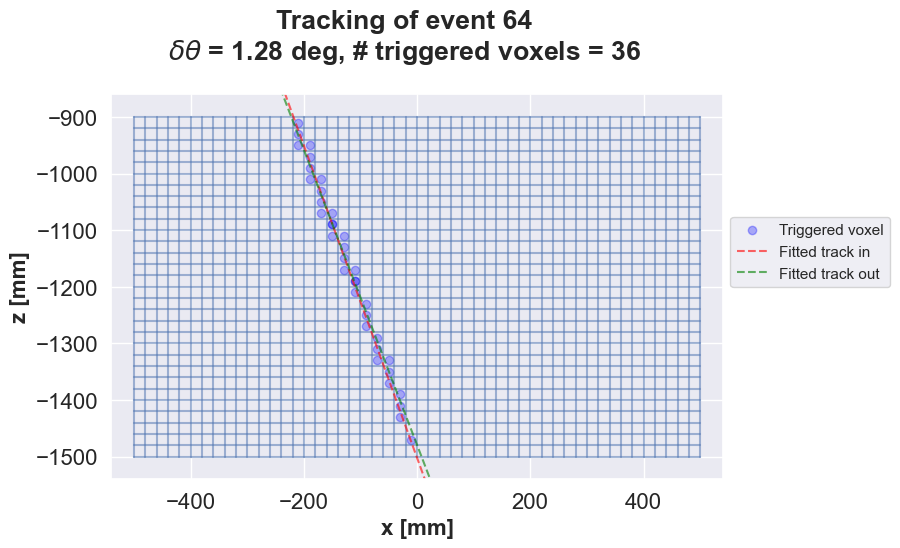

In [87]:
asr.plot_asr_event(
    event = event, # The event to plot 
    proj="XZ",  # The projection (either XZ or YZ) 
    )

## **IV - Predictions**


Similarly to `BCA.xyz_voxel_pred`, the ASR scattering density predictions `ASR.xyz_voxel_pred` is a  $(n_x, n_y, n_z)$ array of `floats`, where $n_i$ is the number of voxels along the $i$ direction.

In [84]:
asr.xyz_voxel_pred.size()


Assigning voxels score


Compute final score


torch.Size([50, 30, 30])

The reconstruction algorithm takes the following parameters as input:

 - `score_method`: Computes the **final** voxel's **score** $S_v$ as a function of the voxel's list $L_v$: $S_v = g(L_v)$, where $g$ is the `score_method`. By default, $g$ is the **median function**.

 - `p_range`: The range of muon momentum to consider, in MeV. Muons with momentum outside of `p_range` will be discarded. $[0, 10]$ TeV by default.

 - `dtheta_range`: The range of scattering angles to consider, in radiants. Muons with scattering angle outside of `p_range` will be discarded. $[0, \pi/3]$ rad by default.

 - `use_p`: Whether to use momentum data or not. `False` by default.

In [94]:
asr.asr_params

{'score_method': functools.partial(<function quantile at 0x7cccacb449b0>, q=0.5),
 'p_range': (0.0, 10000000),
 'dtheta_range': (0.0, 1.0471975511965976),
 'use_p': False}

Let's have a look at the predictions. 

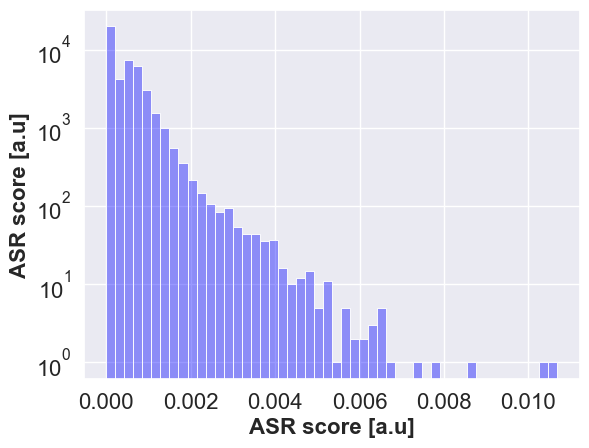

In [104]:
from muograph.plotting.plotting import plot_hist
plot_hist(asr.xyz_voxel_pred.ravel(), xlabel="ASR score [a.u]", logy=True)

Here are the **normalized predictions** computed as:

$$
pred_{norm} = \frac{pred - pred_{min}}{pred_{max} - pred_{min}}
$$


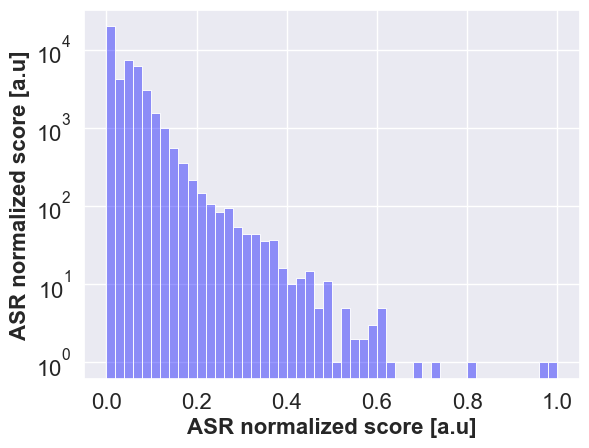

In [105]:
from muograph.plotting.plotting import plot_hist
plot_hist(asr.xyz_voxel_pred_norm.ravel(), xlabel="ASR normalized score [a.u]", logy=True)

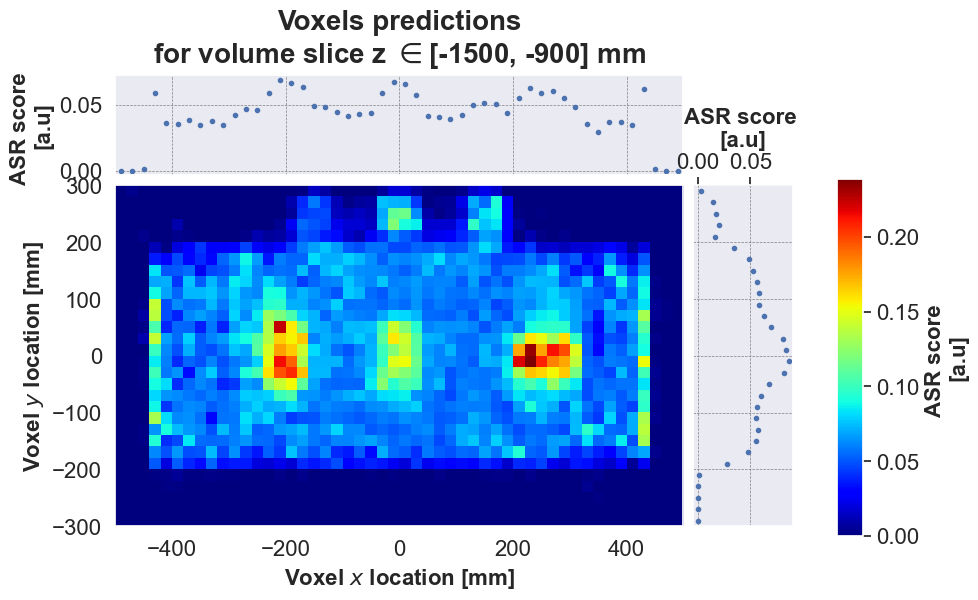

In [106]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 2 

asr.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/asr_default_preds_all_volume", # The name of the figure to save
    pred_label="ASR score",
    pred_unit="\n[a.u]",
)

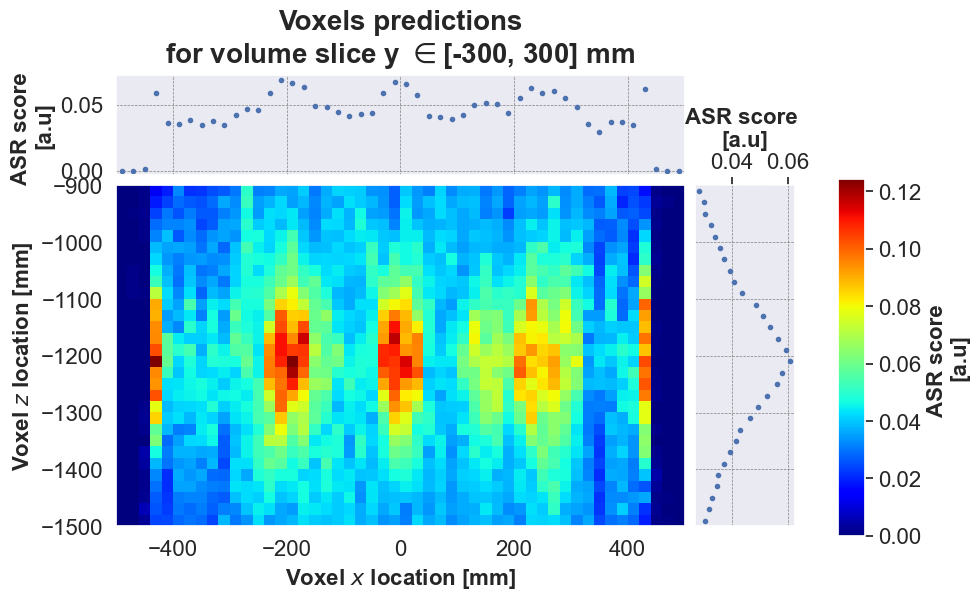

In [107]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 1

asr.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/asr_default_preds_all_volume", # The name of the figure to save
    pred_label="ASR score",
    pred_unit="\n[a.u]",
)

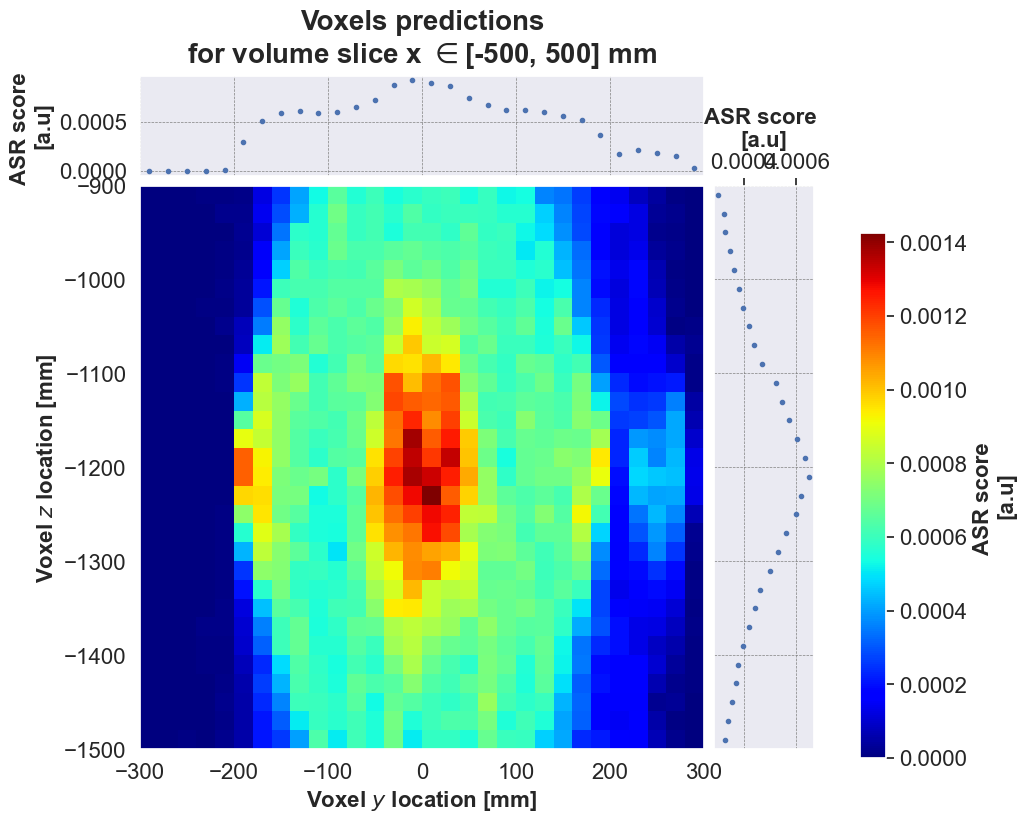

In [108]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 0

asr.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/asr_default_preds_all_volume", # The name of the figure to save
    pred_label="ASR score",
    pred_unit="\n[a.u]",
)

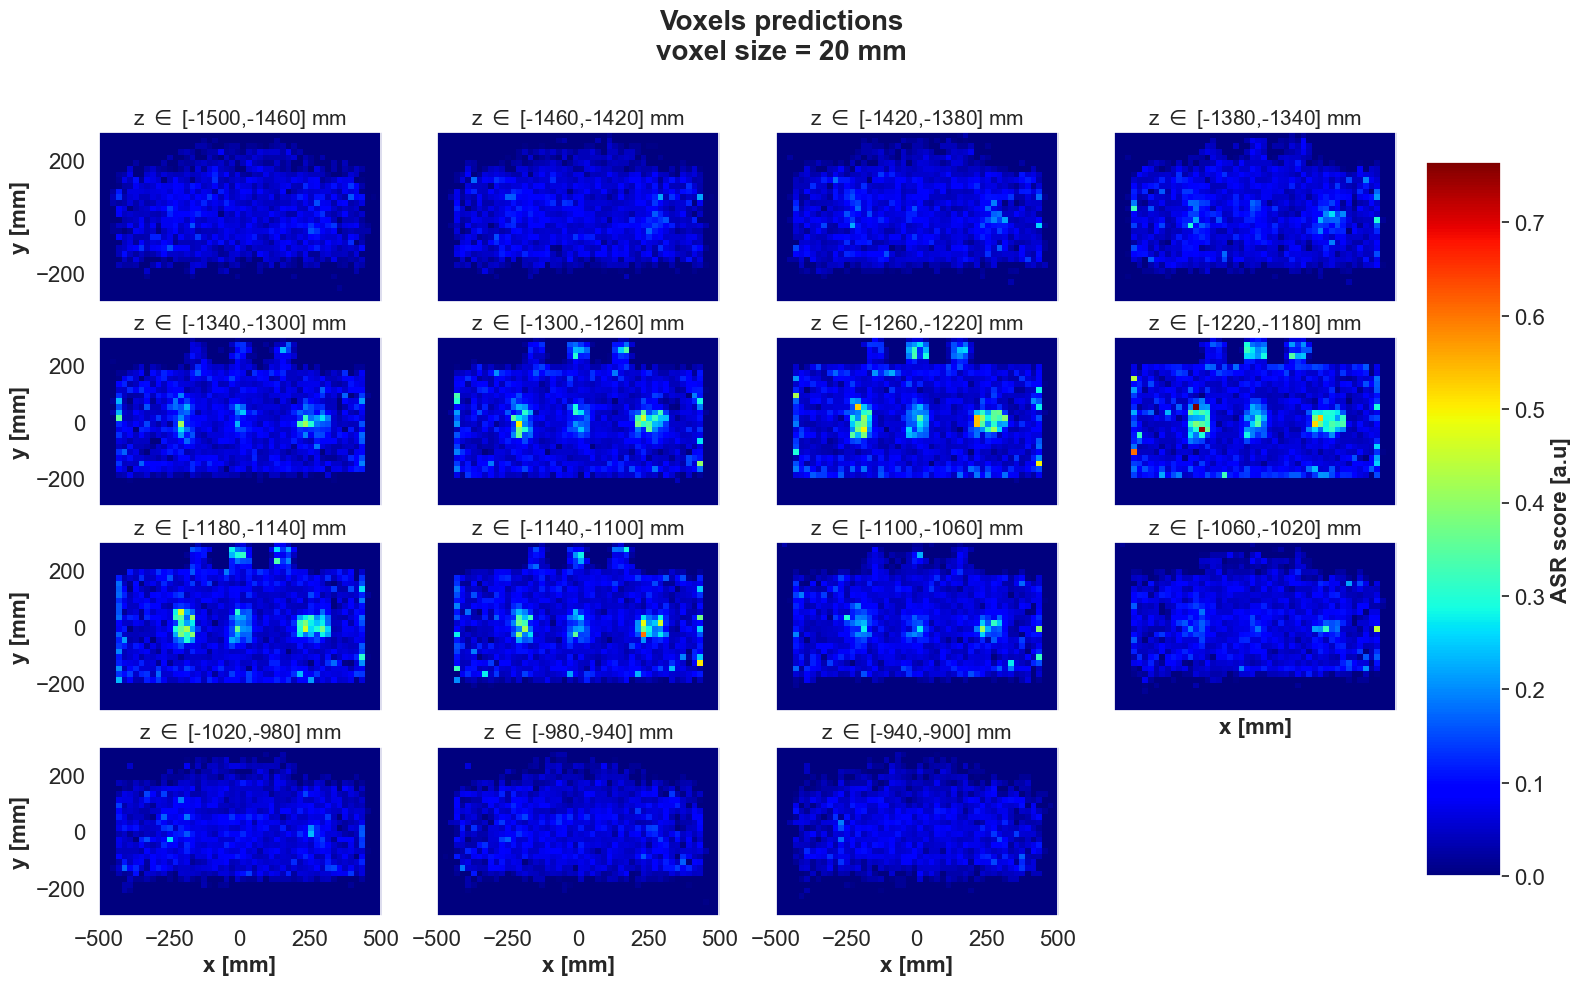

In [110]:
dim = 2

asr.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="ASR score",
    figname = "../output_test/asr_default_preds_slice"
)

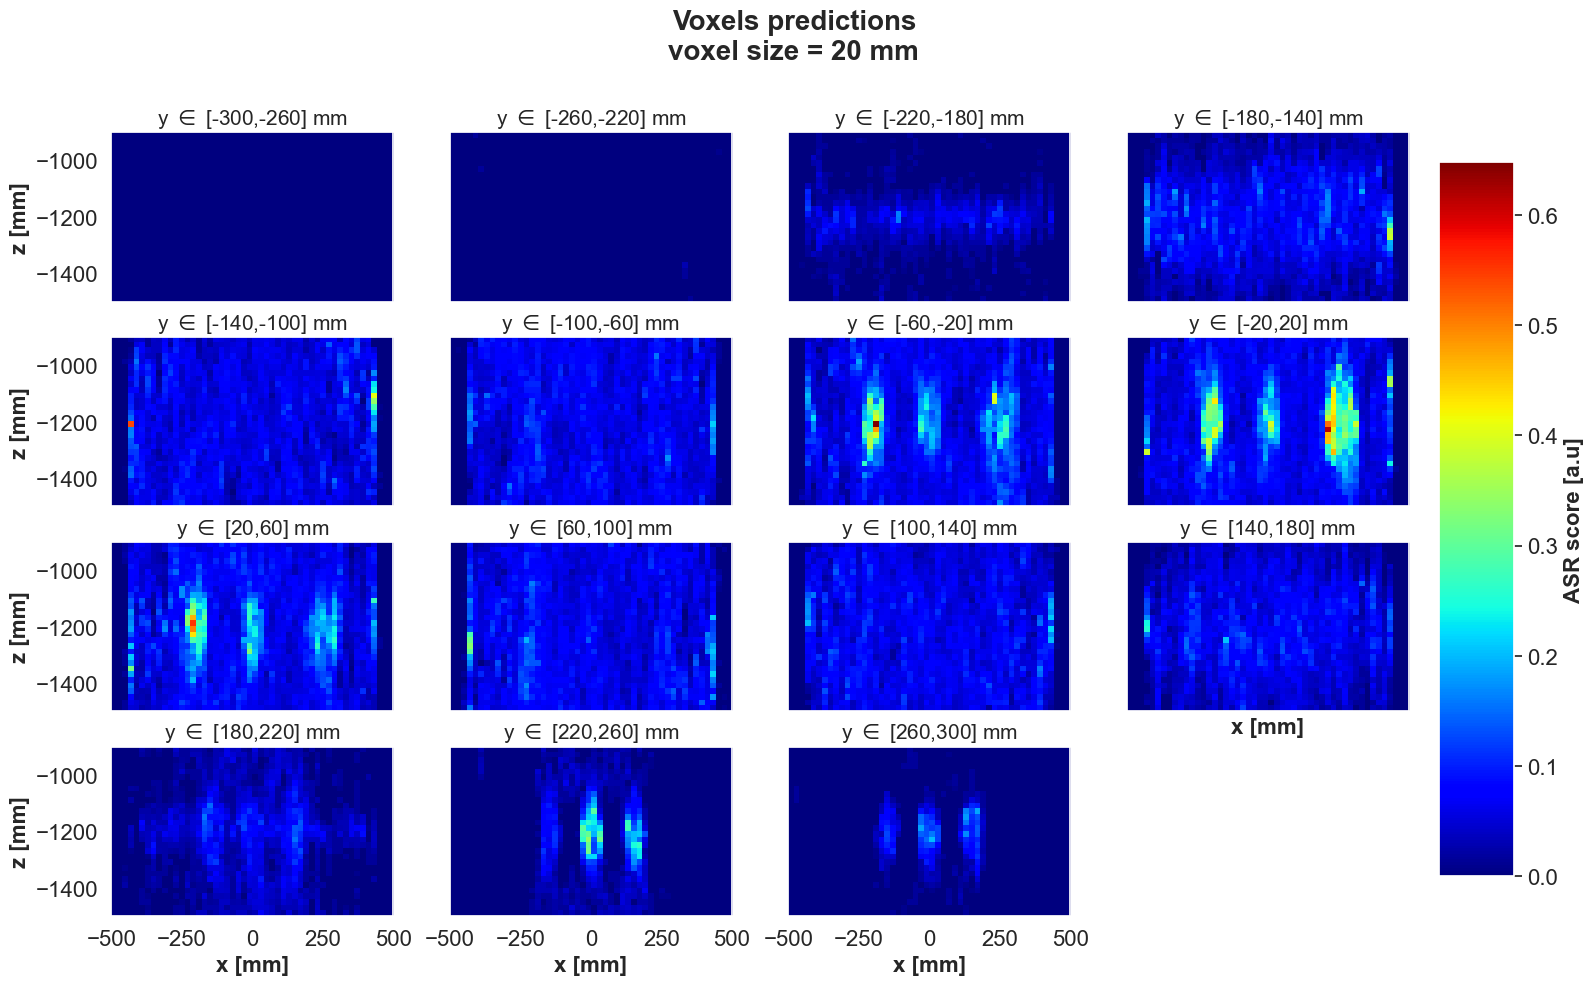

In [116]:
dim = 1

asr.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="ASR score",
    figname = "../output_test/asr_default_preds_slice"
)

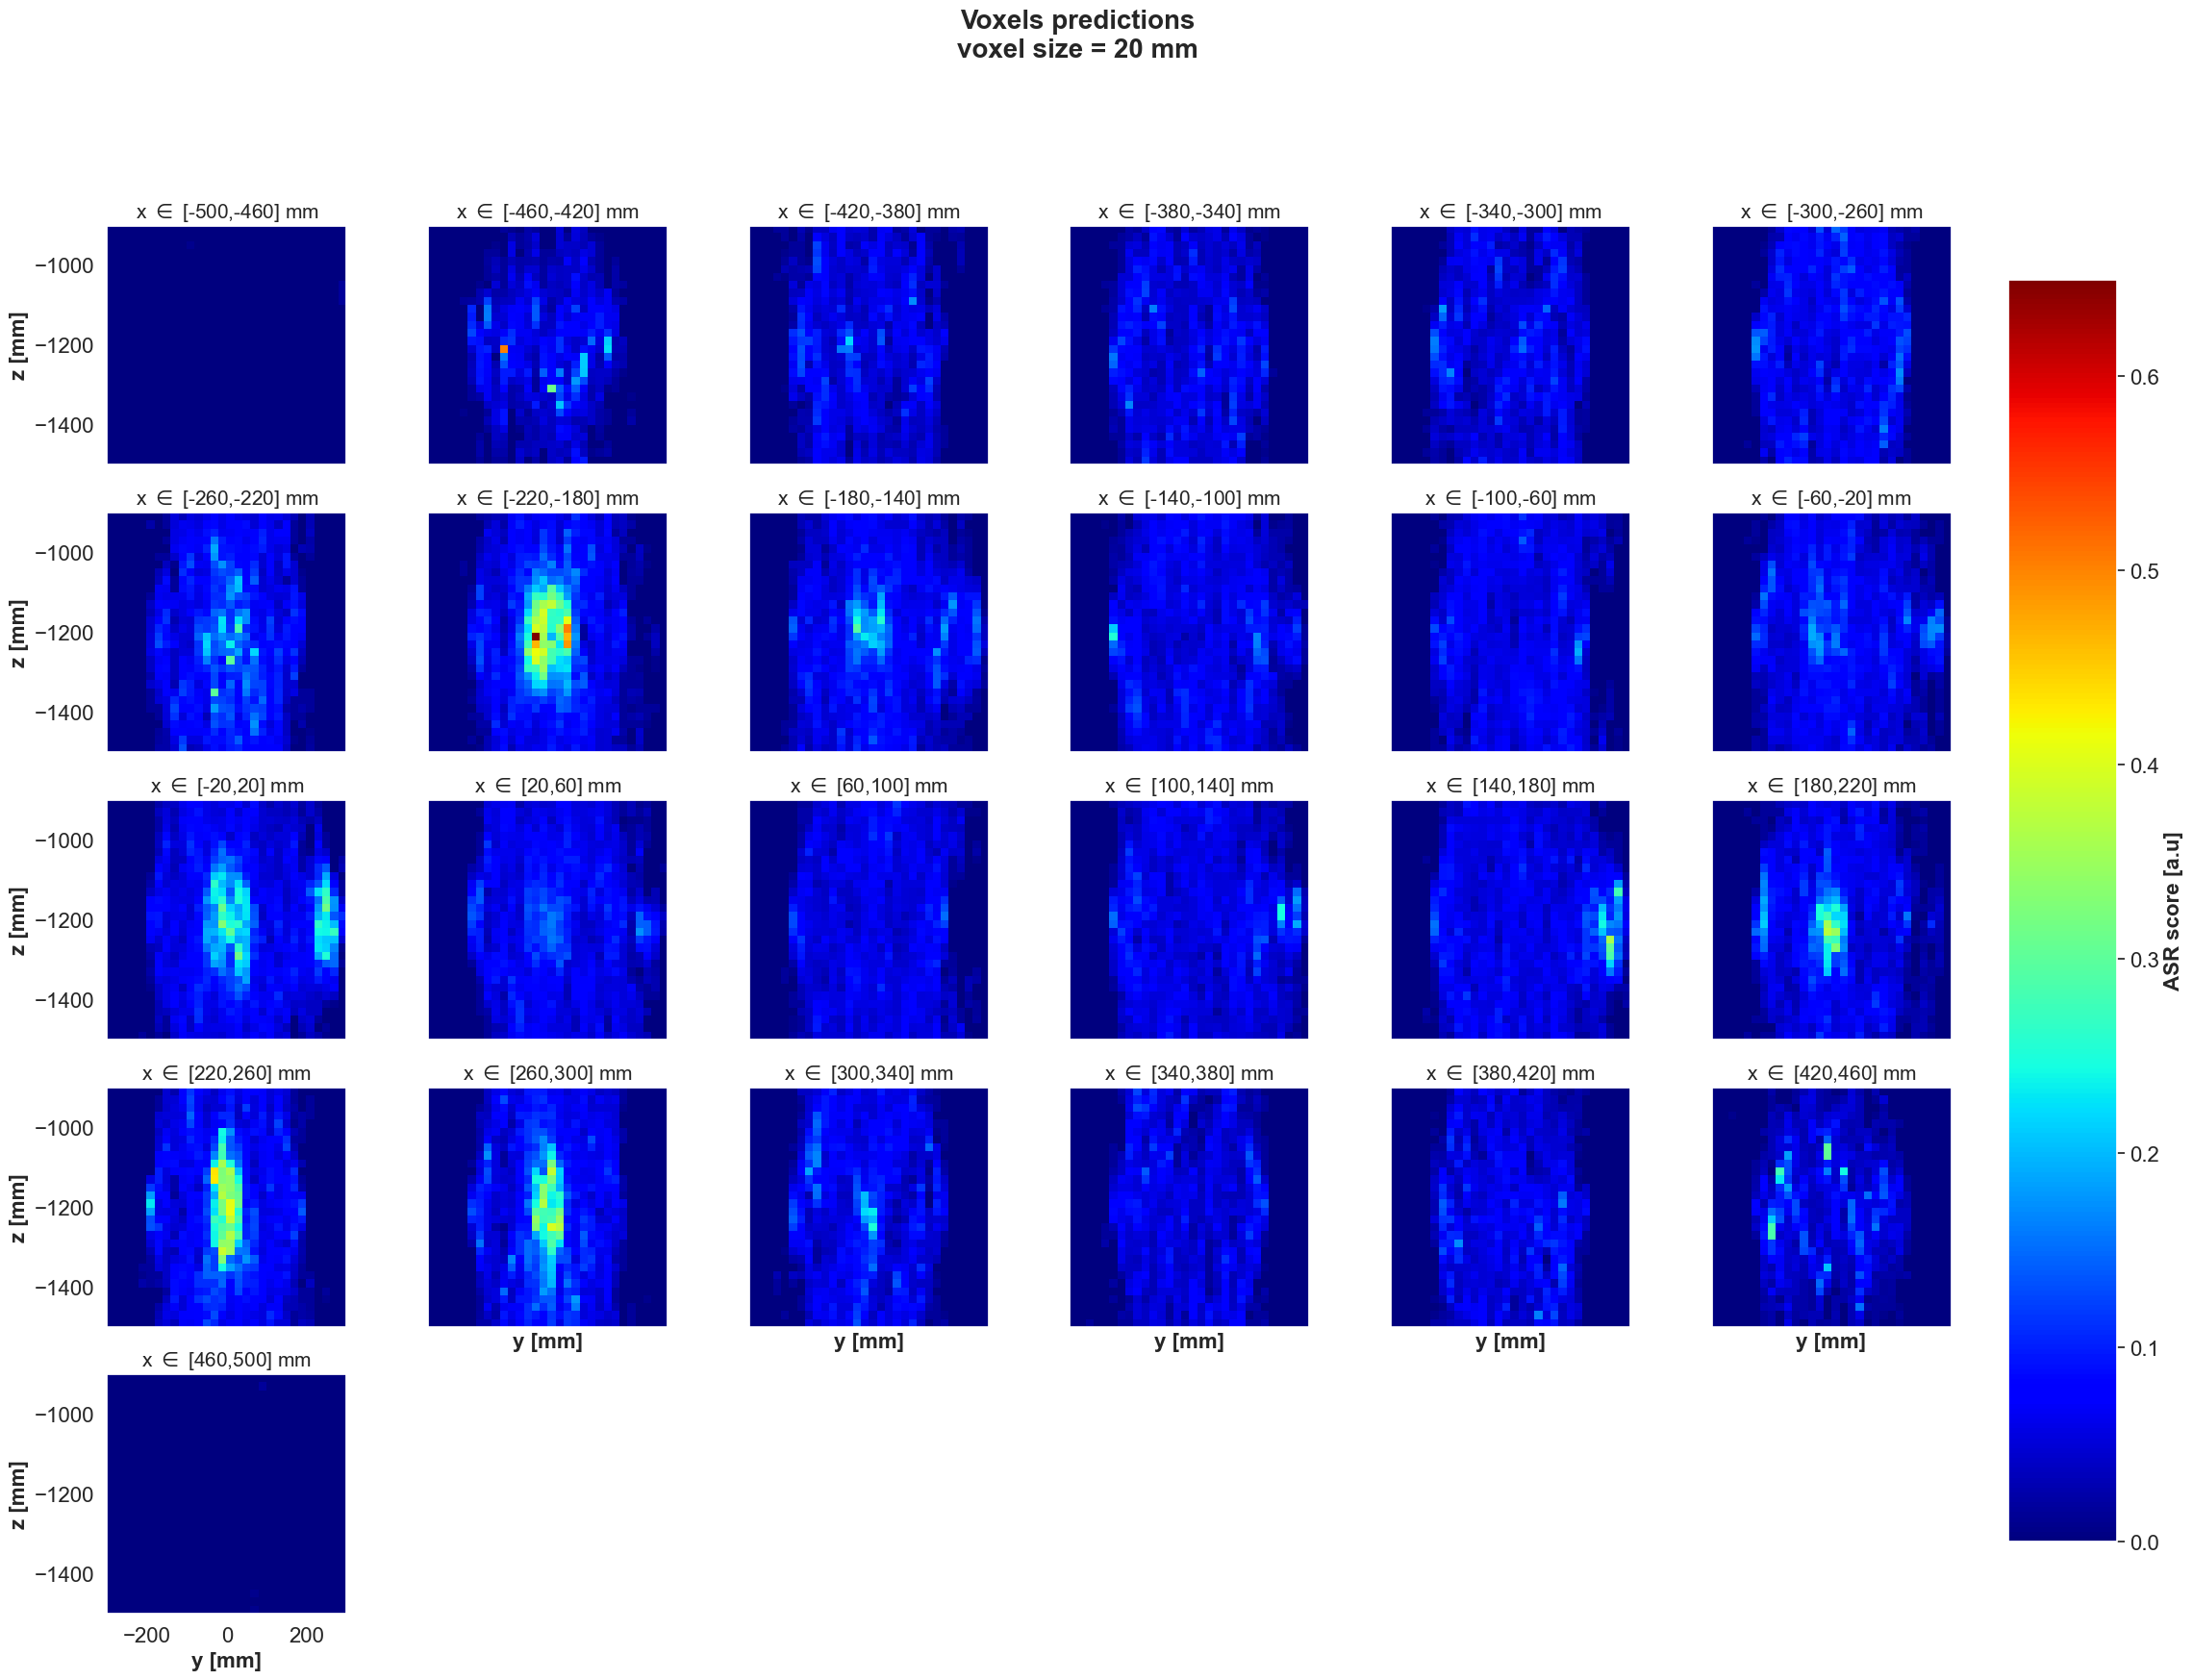

In [117]:
dim = 0

asr.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=6, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="ASR score",
    figname = "../output_test/asr_default_preds_slice"
)

Let's change the parameters of the algorithm and use momentum information:

In [118]:
asr.asr_params = {
        "score_method": partial(np.quantile, q=0.5),
        "p_range": (0.0, 10000000),  # MeV
        "dtheta_range": (0.0, math.pi / 3),
        "use_p": True,
    }

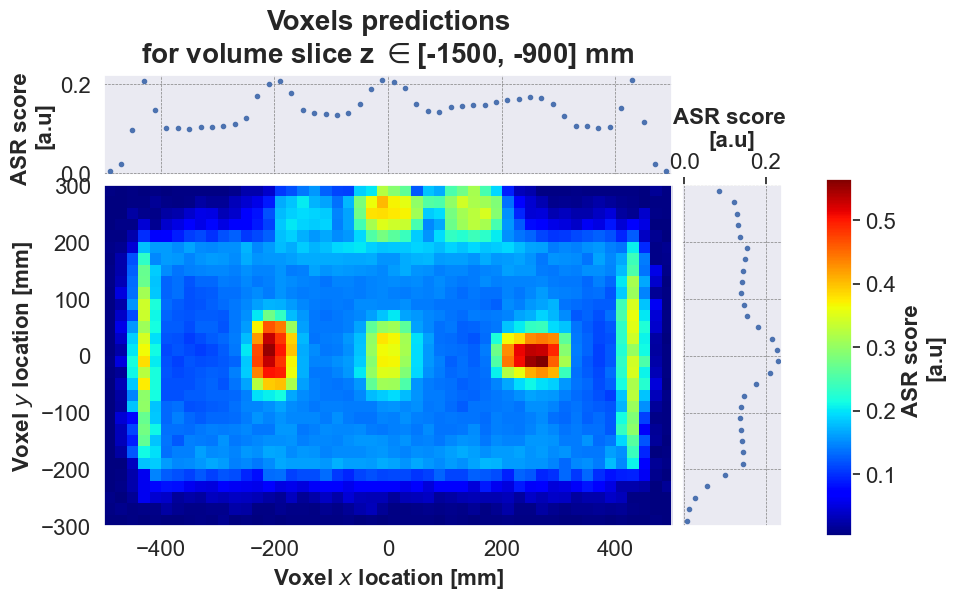

In [120]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 2 

asr.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/asr_preds_use_p_all_volume", # The name of the figure to save
    pred_label="ASR score",
    pred_unit="\n[a.u]",
)

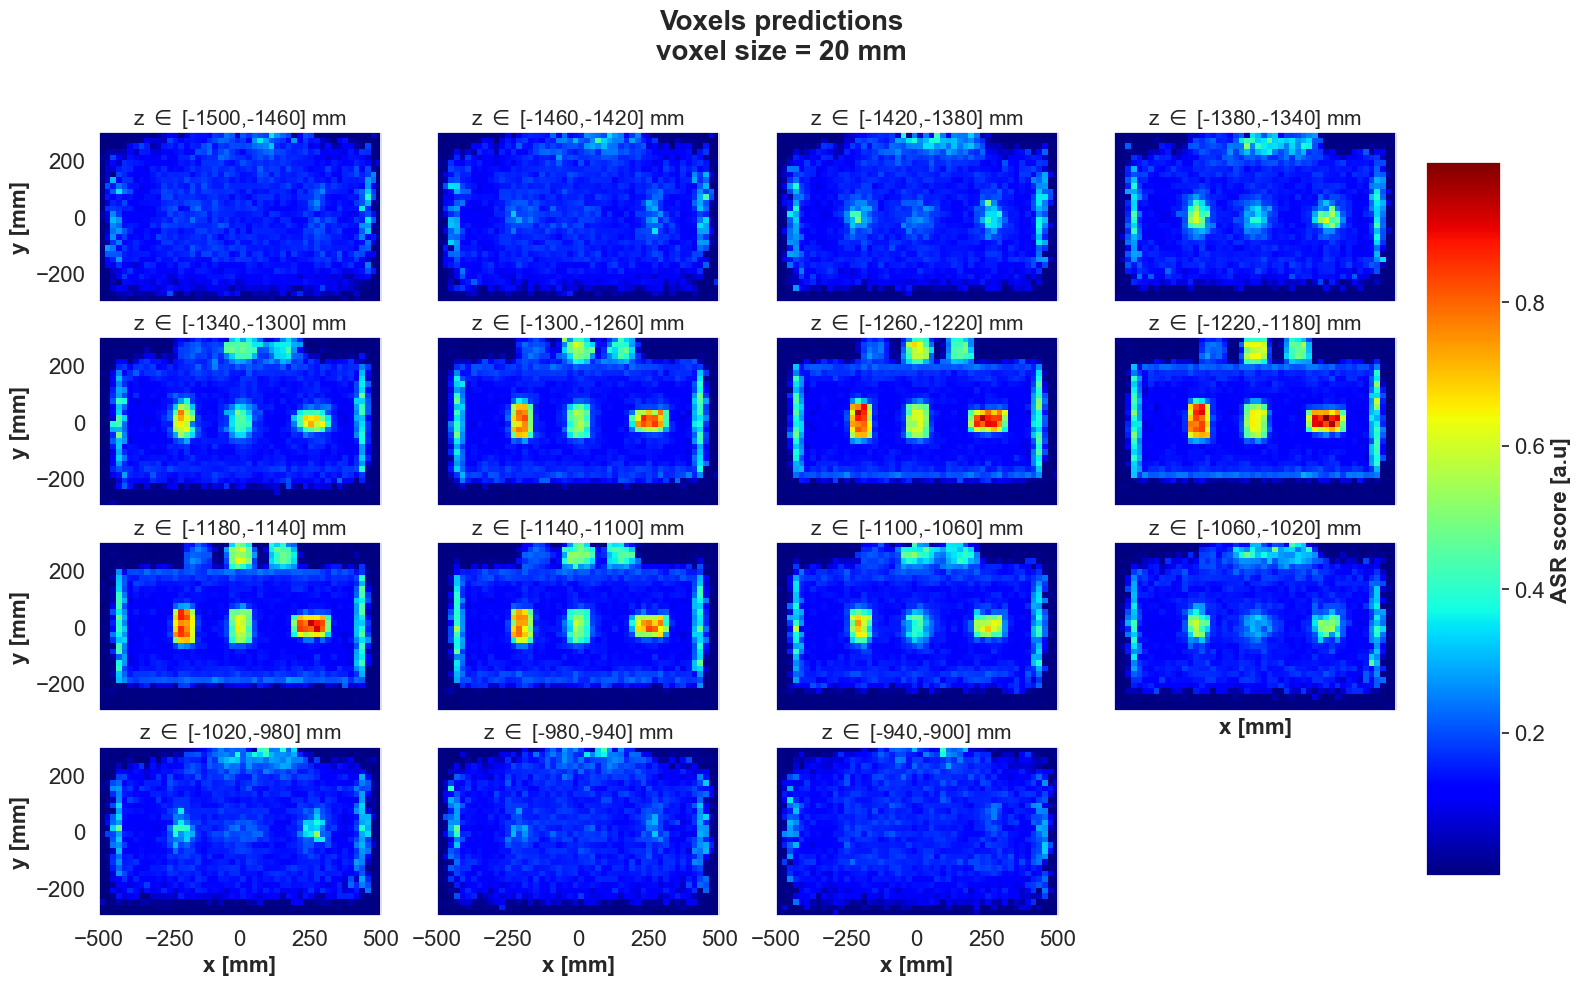

In [121]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 2 

asr.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=asr.xyz_voxel_pred_norm,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="[a.u]",
    pred_label="ASR score",
    figname = "../output_test/asr_use_p_preds_slice"
)